In [2]:
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import torch as pt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [3]:
from astroquery.gaia import Gaia

gaia_query = """

    SELECT TOP 200000
    gdr3.source_id, gdr3.ra, gdr3.dec, gdr3.parallax, gdr3.pmra, gdr3.pmdec, gdr3.phot_g_mean_mag, gdr3.phot_bp_mean_mag, gdr3.phot_rp_mean_mag, 
    gdr3.teff_gspphot, gdr3.logg_gspphot, gdr3.distance_gspphot, gdr3.ag_gspphot, gdr3.azero_gspphot, gdr3.mh_gspphot, gdr3.bp_rp, gdr3.bp_g, gdr3.g_rp,
    gdr3.phot_g_mean_flux, gdr3.phot_bp_mean_flux, gdr3.phot_rp_mean_flux, astro.radius_flame, astro.mass_flame, astro.age_flame, 
    astro.evolstage_flame, astro.lum_flame

    FROM gaiadr3.gaia_source as gdr3
    JOIN gaiadr3.astrophysical_parameters as astro
    ON gdr3.source_id = astro.source_id

    WHERE parallax >0
    AND gdr3.teff_gspphot IS NOT NULL
    AND gdr3.distance_gspphot IS NOT NULL
    AND gdr3.phot_g_mean_mag IS NOT NULL
    AND gdr3.phot_bp_mean_mag IS NOT NULL
    AND radius_flame IS NOT NULL
    AND age_flame IS NOT NULL
    AND lum_flame IS NOT NULL
    AND mass_flame IS NOT NULL
    """

gaia_job = Gaia.launch_job_async(gaia_query)
gaia_data = gaia_job.get_results().to_pandas()

gaia_data.head()

INFO: Query finished. [astroquery.utils.tap.core]


,SOURCE_ID,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,teff_gspphot,...,bp_g,g_rp,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,radius_flame,mass_flame,age_flame,evolstage_flame,lum_flame
0,6030020838301513600,256.461216,-28.454211,0.073901,-4.773396,-6.738861,16.541430,17.256353,15.711174,5308.674316,...,0.714924,0.830256,4553.812996,1709.524922,4118.022743,2.185681,1.159332,6.519261,483,3.360722
1,6030020838301513856,256.467118,-28.449424,0.390357,-3.178060,-0.711247,15.948310,16.418404,15.275753,5664.606934,...,0.470094,0.672557,7863.625456,3698.753885,6149.741014,1.745982,1.045743,9.244729,452,2.764359
2,6030020838301517952,256.459995,-28.450299,0.129218,-2.742661,-3.101740,15.708344,16.391607,14.808374,4842.312988,...,0.683264,0.899969,9808.649251,3791.175791,9458.195607,3.375133,1.061463,9.485735,664,5.631652
3,6030020868250061312,256.480366,-28.436090,0.910130,-3.652339,-4.553047,14.910186,15.326456,14.288694,5935.004395,...,0.416270,0.621491,20458.439882,10111.936937,15264.430445,1.191294,0.962142,10.665052,368,1.368368
4,6030020868250070144,256.472956,-28.433287,0.079913,-5.806520,-4.941893,15.546175,16.348276,14.672168,4825.311035,...,0.802101,0.874007,11388.768367,3945.536500,10722.379618,3.804190,1.070794,9.239058,711,6.961635


In [4]:
gaia_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SOURCE_ID          200000 non-null  int64  
 1   ra                 200000 non-null  float64
 2   dec                200000 non-null  float64
 3   parallax           200000 non-null  float64
 4   pmra               200000 non-null  float64
 5   pmdec              200000 non-null  float64
 6   phot_g_mean_mag    200000 non-null  float32
 7   phot_bp_mean_mag   200000 non-null  float32
 8   phot_rp_mean_mag   200000 non-null  float32
 9   teff_gspphot       200000 non-null  float32
 10  logg_gspphot       200000 non-null  float32
 11  distance_gspphot   200000 non-null  float32
 12  ag_gspphot         200000 non-null  float32
 13  azero_gspphot      200000 non-null  float32
 14  mh_gspphot         200000 non-null  float32
 15  bp_rp              200000 non-null  float32
 16  bp

In [5]:
gaia_data.describe()

,SOURCE_ID,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,teff_gspphot,...,bp_g,g_rp,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,radius_flame,mass_flame,age_flame,evolstage_flame,lum_flame
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,5.075153e+18,249.795165,-25.110712,0.519515,-2.619763,-3.627645,16.310543,17.049086,15.493958,5197.424805,...,0.738547,0.816583,2.245338e+04,1.086963e+04,1.697184e+04,3.157401,1.214572,5.708088,392.849430,17.794977
std,8.550264e+17,37.377084,32.951186,0.523769,4.532618,6.076110,1.286141,1.434621,1.228565,892.633545,...,0.382178,0.229738,4.713161e+05,2.978804e+05,2.731541e+05,5.444329,0.647617,4.200360,186.883506,74.064766
min,2.263181e+18,156.322594,-64.369877,0.000016,-155.030946,-319.047085,5.356526,5.371217,5.302628,3144.024170,...,-0.286216,0.011812,9.439777e+02,3.833890e+01,6.806654e+02,0.390365,0.502292,0.200124,100.000000,0.030117
25%,4.498690e+18,255.350999,-56.502662,0.187891,-4.857780,-6.556278,15.601118,16.199980,14.818038,4695.770874,...,0.455407,0.635206,2.327491e+03,7.696187e+02,2.126502e+03,0.822976,0.782746,1.842564,255.000000,0.323121
50%,5.253655e+18,265.086465,-28.757466,0.429787,-2.471399,-3.763798,16.491366,17.245270,15.643073,5000.136719,...,0.616355,0.764544,4.768701e+03,1.727065e+03,4.384589e+03,1.354201,0.981202,4.862999,358.000000,1.812738
75%,5.917332e+18,267.426630,5.434273,0.670414,-0.193457,-0.227017,17.270146,18.122853,16.428731,5518.933105,...,0.926339,0.981869,1.082679e+04,4.522983e+03,9.374388e+03,3.110883,1.369763,9.518143,516.000000,7.772567
max,6.030135e+18,316.668803,76.031017,41.474060,78.554014,91.503113,18.249962,21.379442,17.665562,11942.231445,...,5.121212,2.006766,1.356240e+08,9.703534e+07,5.999387e+07,168.745392,3.811549,13.499977,1289.000000,3426.328613


<Axes: xlabel='ra', ylabel='dec'>

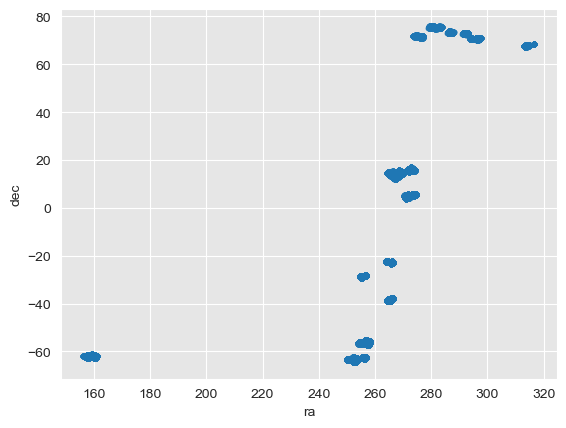

In [6]:
gaia_data.plot.scatter(x='ra', y='dec', s=10)

In [7]:
Dataset = gaia_data.copy()#.drop(columns = ["classprob_dsc_combmod_star", "classprob_dsc_combmod_whitedwarf", "classprob_dsc_combmod_binarystar", "classprob_dsc_combmod_quasar", "classprob_dsc_combmod_galaxy"])
Dataset.dropna(inplace = True)
Dataset.to_csv("Stellar_Dataset2.csv", index = False)